<h1><center>CSE 8803 Machine Learning for Computational Biology Final Project Code</center></h1>

This file contains the code for our final project. We are trying to predict toxicity of chemicals on SR-p53 using the Tox21 dataset (retrieved from this website: https://moleculenet.org/datasets-1). In this notebook, we are training the following models:



1.   Logistic Regression
2.   Support Vector Machine (Support Vector Classifier)
3.   Random Forest Classifier
4.   Graph Neural Network for Classification 


**Note:** To run this notebook, it is important that we have access to the tox21.csv file which is found on the above mentioned website.

Below we are first installing all the libraries that we need to successfully run the notebook.

In [ ]:
pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install dgllife

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install dgl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Below are the imported libraries for this notebook.

In [ ]:
#imports for this project
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, classification_report
from dgllife.utils import mol_to_complete_graph
from sklearn.ensemble import RandomForestClassifier

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


The rest of the notebook will be divided into the following sections:



*   Preprocessing
*   Non Graph Approach (Based on Simple Descriptor Features)
*   Model Development for Non Graph Approach (includes model development for undersampling and oversampling techniques for all three machine learning models)
*   Graph Approach 



# Preprocessing

We are first loading the csv file values into a Pandas dataframe.

In [ ]:
df = pd.read_csv("/content/tox21.csv")
df

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX2725,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...
7827,1.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,TOX2370,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...
7828,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX2371,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...
7829,1.0,1.0,0.0,NaN,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,TOX2377,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...


Below we are trying to extract only the smiles and SR-p53 columns because those are the two columns we need for this project.

In [ ]:
srP53Data = df[['smiles','SR-p53']]
srP53Data

,smiles,SR-p53
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.0
2,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...,NaN
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0
4,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0
...,...,...
7826,CCOc1nc2cccc(C(=O)O)c2n1Cc1ccc(-c2ccccc2-c2nnn...,NaN
7827,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...,0.0
7828,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...,0.0
7829,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...,1.0


In [ ]:
srP53Data['SR-p53'].value_counts()

0.0    6351
1.0     423
Name: SR-p53, dtype: int64

Next, we are essentially dropping all the rows with NaN values. This is because we don't think it would be a good idea to make assumptions about missing values especially for this particular scenario. For instance, the chemical compound might have a target label value of 1 instead of a 0 or vice versa. Therefore, we felt it was best to drop rows with missing values. This did not affect the overall quality and distribution of the dataset (the number of observations per class was still imbalanced).

In [ ]:
srP53Data.dropna(inplace=True)

<ipython-input-39-262f040a11b3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  srP53Data.dropna(inplace=True)


Below we are trying to create a count plot to show the frequency for each of the target labels. We have an imbalanced dataset because the number of 0 labels exceeds the number of 1 labels.

In [ ]:
srP53Data['SR-p53'].value_counts()

0.0    6351
1.0     423
Name: SR-p53, dtype: int64

In [ ]:
nonToxic = srP53Data[srP53Data['SR-p53']==0]
toxic = srP53Data[srP53Data['SR-p53']==1]

In [ ]:
print(f"Percent of data that has toxic label: {round(((len(toxic))/(len(nonToxic) + len(toxic))) * 100,3)}%")

Percent of data that has toxic label: 6.244%


In [ ]:
print(f"Percent of data that has non toxic label: {round(((len(nonToxic))/(len(nonToxic) + len(toxic))) * 100,3)}%")

Percent of data that has non toxic label: 93.756%


[Text(0.5, 1.0, 'Number of Observations for Target Labels'),
 Text(0, 0.5, 'Number of Observations'),
 Text(0.5, 0, 'Target Labels')]

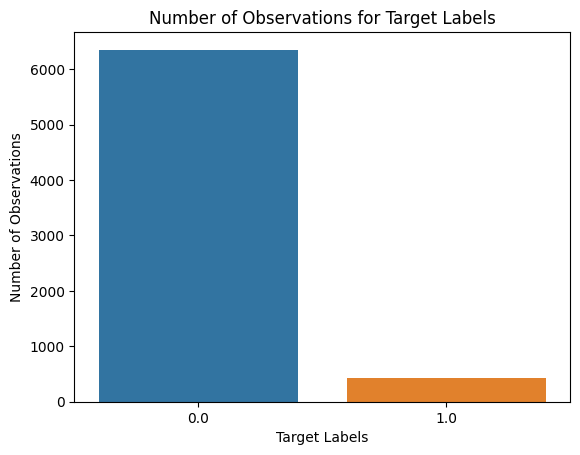

In [ ]:
sns.countplot(x=srP53Data['SR-p53']).set(title="Number of Observations for Target Labels",ylabel="Number of Observations",xlabel="Target Labels")

# Non Graph Approach (Based on Simple Descriptor Features)

Our first approach is a non graph approach. In this approach, we get the molecular descriptors for each of the SMILES strings and try to see which of these descriptors can be used to predict the toxicity for SR-p53.

In [ ]:
#we are first getting all the smiles strings in our dataframe
smilesStrings = list(srP53Data['smiles'])

1. The chosen descriptors shown below was retrieved from this website: https://www.blopig.com/blog/2022/06/how-to-turn-a-molecule-into-a-vector-of-physicochemical-descriptors-using-rdkit/ 


2. The simple descriptor features were retrieved from this paper: https://arxiv.org/pdf/2011.13230.pdf


**Note:** we selected the simple descriptor features because these are the commonly used descriptor features as mentioned in the above paper.

In [ ]:
chosenDescriptorsFeatures = ['BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'EState_VSA1', 'EState_VSA10', 'EState_VSA11', 'EState_VSA2', 'EState_VSA3', 'EState_VSA4', 'EState_VSA5', 'EState_VSA6', 'EState_VSA7', 'EState_VSA8', 'EState_VSA9', 'ExactMolWt', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'FractionCSP3', 'HallKierAlpha', 'HeavyAtomCount', 'HeavyAtomMolWt', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'MaxAbsEStateIndex', 'MaxAbsPartialCharge', 'MaxEStateIndex', 'MaxPartialCharge', 'MinAbsEStateIndex', 'MinAbsPartialCharge', 'MinEStateIndex', 'MinPartialCharge', 'MolLogP', 'MolMR', 'MolWt', 'NHOHCount', 'NOCount', 'NumAliphaticCarbocycles', 'NumAliphaticHeterocycles', 'NumAliphaticRings', 'NumAromaticCarbocycles', 'NumAromaticHeterocycles', 'NumAromaticRings', 'NumHAcceptors', 'NumHDonors', 'NumHeteroatoms', 'NumRadicalElectrons', 'NumRotatableBonds', 'NumSaturatedCarbocycles', 'NumSaturatedHeterocycles', 'NumSaturatedRings', 'NumValenceElectrons', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'RingCount', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'TPSA', 'VSA_EState1', 'VSA_EState10', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'VSA_EState8', 'VSA_EState9', 'fr_Al_COO', 'fr_Al_OH', 'fr_Al_OH_noTert', 'fr_ArN', 'fr_Ar_COO', 'fr_Ar_N', 'fr_Ar_NH', 'fr_Ar_OH', 'fr_COO', 'fr_COO2', 'fr_C_O', 'fr_C_O_noCOO', 'fr_C_S', 'fr_HOCCN', 'fr_Imine', 'fr_NH0', 'fr_NH1', 'fr_NH2', 'fr_N_O', 'fr_Ndealkylation1', 'fr_Ndealkylation2', 'fr_Nhpyrrole', 'fr_SH', 'fr_aldehyde', 'fr_alkyl_carbamate', 'fr_alkyl_halide', 'fr_allylic_oxid', 'fr_amide', 'fr_amidine', 'fr_aniline', 'fr_aryl_methyl', 'fr_azide', 'fr_azo', 'fr_barbitur', 'fr_benzene', 'fr_benzodiazepine', 'fr_bicyclic', 'fr_diazo', 'fr_dihydropyridine', 'fr_epoxide', 'fr_ester', 'fr_ether', 'fr_furan', 'fr_guanido', 'fr_halogen', 'fr_hdrzine', 'fr_hdrzone', 'fr_imidazole', 'fr_imide', 'fr_isocyan', 'fr_isothiocyan', 'fr_ketone', 'fr_ketone_Topliss', 'fr_lactam', 'fr_lactone', 'fr_methoxy', 'fr_morpholine', 'fr_nitrile', 'fr_nitro', 'fr_nitro_arom', 'fr_nitro_arom_nonortho', 'fr_nitroso', 'fr_oxazole', 'fr_oxime', 'fr_para_hydroxylation', 'fr_phenol', 'fr_phenol_noOrthoHbond', 'fr_phos_acid', 'fr_phos_ester', 'fr_piperdine', 'fr_piperzine', 'fr_priamide', 'fr_prisulfonamd', 'fr_pyridine', 'fr_quatN', 'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane', 'fr_urea', 'qed']

In [ ]:
simpleDescriptorFeatures = ['FpDensityMorgan2', 'FractionCSP3', 'MolLogP', 'MolWt', 'NumHAcceptors', 'NumHDonors', 'NumRotatableBonds', 'TPSA']

We are now trying to obtain the indexes for the each of the simple descriptor features from the chosenDescriptorsFeatures list. 

In [ ]:
simpleDescriptorFeaturesIndexes = []

for simpleDescriptorFeature in simpleDescriptorFeatures:
  simpleDescriptorFeaturesIndexes.append(chosenDescriptorsFeatures.index(simpleDescriptorFeature))

Now, we are trying to get the values for each of the simple descriptor features for all the rows in the dataframe. In other words, we are trying to get the simple descriptor features for all the SMILES strings in the dataframe. 


In the implementation below, the value for each of the simple descriptor feature gets assigned to a separate list. Also, this implementation is based off this website: https://www.blopig.com/blog/2022/06/how-to-turn-a-molecule-into-a-vector-of-physicochemical-descriptors-using-rdkit/

In [ ]:
FpDensityMorgan2List = []
FractionCSP3List = []
MolLogPList = []
MolWtList = []
NumHAcceptorsList = []
NumHDonorsList = []
NumRotatableBondsList = []
TPSAList = []


for smilesString in smilesStrings:
  mol = Chem.MolFromSmiles(smilesString)
  molDescriptorCalculator = MolecularDescriptorCalculator(chosenDescriptorsFeatures)
  listOfDescriptorValues = list(molDescriptorCalculator.CalcDescriptors(mol))
  FpDensityMorgan2List.append(listOfDescriptorValues[simpleDescriptorFeaturesIndexes[0]])
  FractionCSP3List.append(listOfDescriptorValues[simpleDescriptorFeaturesIndexes[1]])
  MolLogPList.append(listOfDescriptorValues[simpleDescriptorFeaturesIndexes[2]])
  MolWtList.append(listOfDescriptorValues[simpleDescriptorFeaturesIndexes[3]])
  NumHAcceptorsList.append(listOfDescriptorValues[simpleDescriptorFeaturesIndexes[4]])
  NumHDonorsList.append(listOfDescriptorValues[simpleDescriptorFeaturesIndexes[5]])
  NumRotatableBondsList.append(listOfDescriptorValues[simpleDescriptorFeaturesIndexes[6]])
  TPSAList.append(listOfDescriptorValues[simpleDescriptorFeaturesIndexes[7]])


Now we add the above lists into our dataframe

In [ ]:
srP53Data.loc[:,'FpDensityMorgan2'] = FpDensityMorgan2List
srP53Data.loc[:,'FractionCSP3'] = FractionCSP3List
srP53Data.loc[:,'MolLogP'] = MolLogPList
srP53Data.loc[:,'MolWt'] = MolWtList
srP53Data.loc[:,'NumHAcceptors'] = NumHAcceptorsList
srP53Data.loc[:,'NumHDonors'] = NumHDonorsList
srP53Data.loc[:,'NumRotatableBonds'] = NumRotatableBondsList
srP53Data.loc[:,'TPSA'] = TPSAList

<ipython-input-50-535adec1ecea>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  srP53Data.loc[:,'FpDensityMorgan2'] = FpDensityMorgan2List
<ipython-input-50-535adec1ecea>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  srP53Data.loc[:,'FractionCSP3'] = FractionCSP3List
<ipython-input-50-535adec1ecea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyd

We are now taking a look at the dataset to see if everything is formatted correctly.

In [ ]:
srP53Data

,smiles,SR-p53,FpDensityMorgan2,FractionCSP3,MolLogP,MolWt,NumHAcceptors,NumHDonors,NumRotatableBonds,TPSA
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0.0,2.250000,0.222222,1.34240,258.324,5,1,3,82.28
1,CCN1C(=O)NC(c2ccccc2)C1=O,0.0,1.933333,0.272727,1.29940,204.229,2,1,2,49.41
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0.0,1.800000,0.588235,3.75244,276.424,2,1,7,32.34
4,CC(O)(P(=O)(O)O)P(=O)(O)O,0.0,1.181818,1.000000,-0.99220,206.027,3,5,2,135.29
5,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,0.0,0.700000,1.000000,4.81720,290.444,4,0,7,36.92
...,...,...,...,...,...,...,...,...,...,...
7825,CCCNCC(O)COc1ccccc1C(=O)CCc1ccccc1,0.0,1.840000,0.380952,3.24140,341.451,4,2,11,58.56
7827,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...,0.0,1.826087,0.809524,4.72350,314.469,2,0,1,34.14
7828,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...,0.0,1.857143,0.842105,3.87920,288.431,2,1,0,37.30
7829,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...,1.0,2.000000,0.666667,3.60920,272.388,2,2,0,40.46


We are now performing the following steps:


1.   Getting rid of the smiles column as we no longer need it for this approach
2.   Changing the type of the SR-p53 column (target labels) from float to int


In [ ]:
srP53Data.drop(['smiles'],axis=1,inplace=True)

<ipython-input-52-ecd735f06c7b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  srP53Data.drop(['smiles'],axis=1,inplace=True)


In [ ]:
srP53Data['SR-p53'] = srP53Data['SR-p53'].astype("int")

<ipython-input-53-247ebf6741c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  srP53Data['SR-p53'] = srP53Data['SR-p53'].astype("int")


We assign X to be all the columns except SR-p53 because the SR-p53 column contains our target labels. Likewise we assign y to contain the values in the SR-p53 column.

In [ ]:
X = srP53Data.loc[:,srP53Data.columns != "SR-p53"]
y = srP53Data["SR-p53"]
y = y.astype('int')

In [ ]:
X

,FpDensityMorgan2,FractionCSP3,MolLogP,MolWt,NumHAcceptors,NumHDonors,NumRotatableBonds,TPSA
0,2.250000,0.222222,1.34240,258.324,5,1,3,82.28
1,1.933333,0.272727,1.29940,204.229,2,1,2,49.41
3,1.800000,0.588235,3.75244,276.424,2,1,7,32.34
4,1.181818,1.000000,-0.99220,206.027,3,5,2,135.29
5,0.700000,1.000000,4.81720,290.444,4,0,7,36.92
...,...,...,...,...,...,...,...,...
7825,1.840000,0.380952,3.24140,341.451,4,2,11,58.56
7827,1.826087,0.809524,4.72350,314.469,2,0,1,34.14
7828,1.857143,0.842105,3.87920,288.431,2,1,0,37.30
7829,2.000000,0.666667,3.60920,272.388,2,2,0,40.46


Below we are using a sklearn function called SelectKBest in order to **select the 3 best features** for our models. f_classif was chosen as the score function since it is most suitable for classification tasks.

In [ ]:
X_new = SelectKBest(score_func=f_classif, k=3).fit_transform(X,y)

In [ ]:
X_new

array([[2.22222222e-01, 2.58324000e+02, 5.00000000e+00],
       [2.72727273e-01, 2.04229000e+02, 2.00000000e+00],
       [5.88235294e-01, 2.76424000e+02, 2.00000000e+00],
       ...,
       [8.42105263e-01, 2.88431000e+02, 2.00000000e+00],
       [6.66666667e-01, 2.72388000e+02, 2.00000000e+00],
       [4.00000000e-01, 3.39391000e+02, 5.00000000e+00]])

Based on the values for each of the three columns in X_new, we can see that the SelectKBest method selected **FractionCSP3**, **MolWt**, **NumHAcceptors** as our 3 best features.

Normalizing the data is normally a good idea before training a model. We are following this practice by using StandardScaler()

In [ ]:
scaler = StandardScaler()
scaler.fit(X_new)
X_new_standarized = scaler.transform(X_new)

## Model Development 

We utilize the knowledge from the lecture slide shown below to successfully use all the three sets (training, validation, and test) for model development.

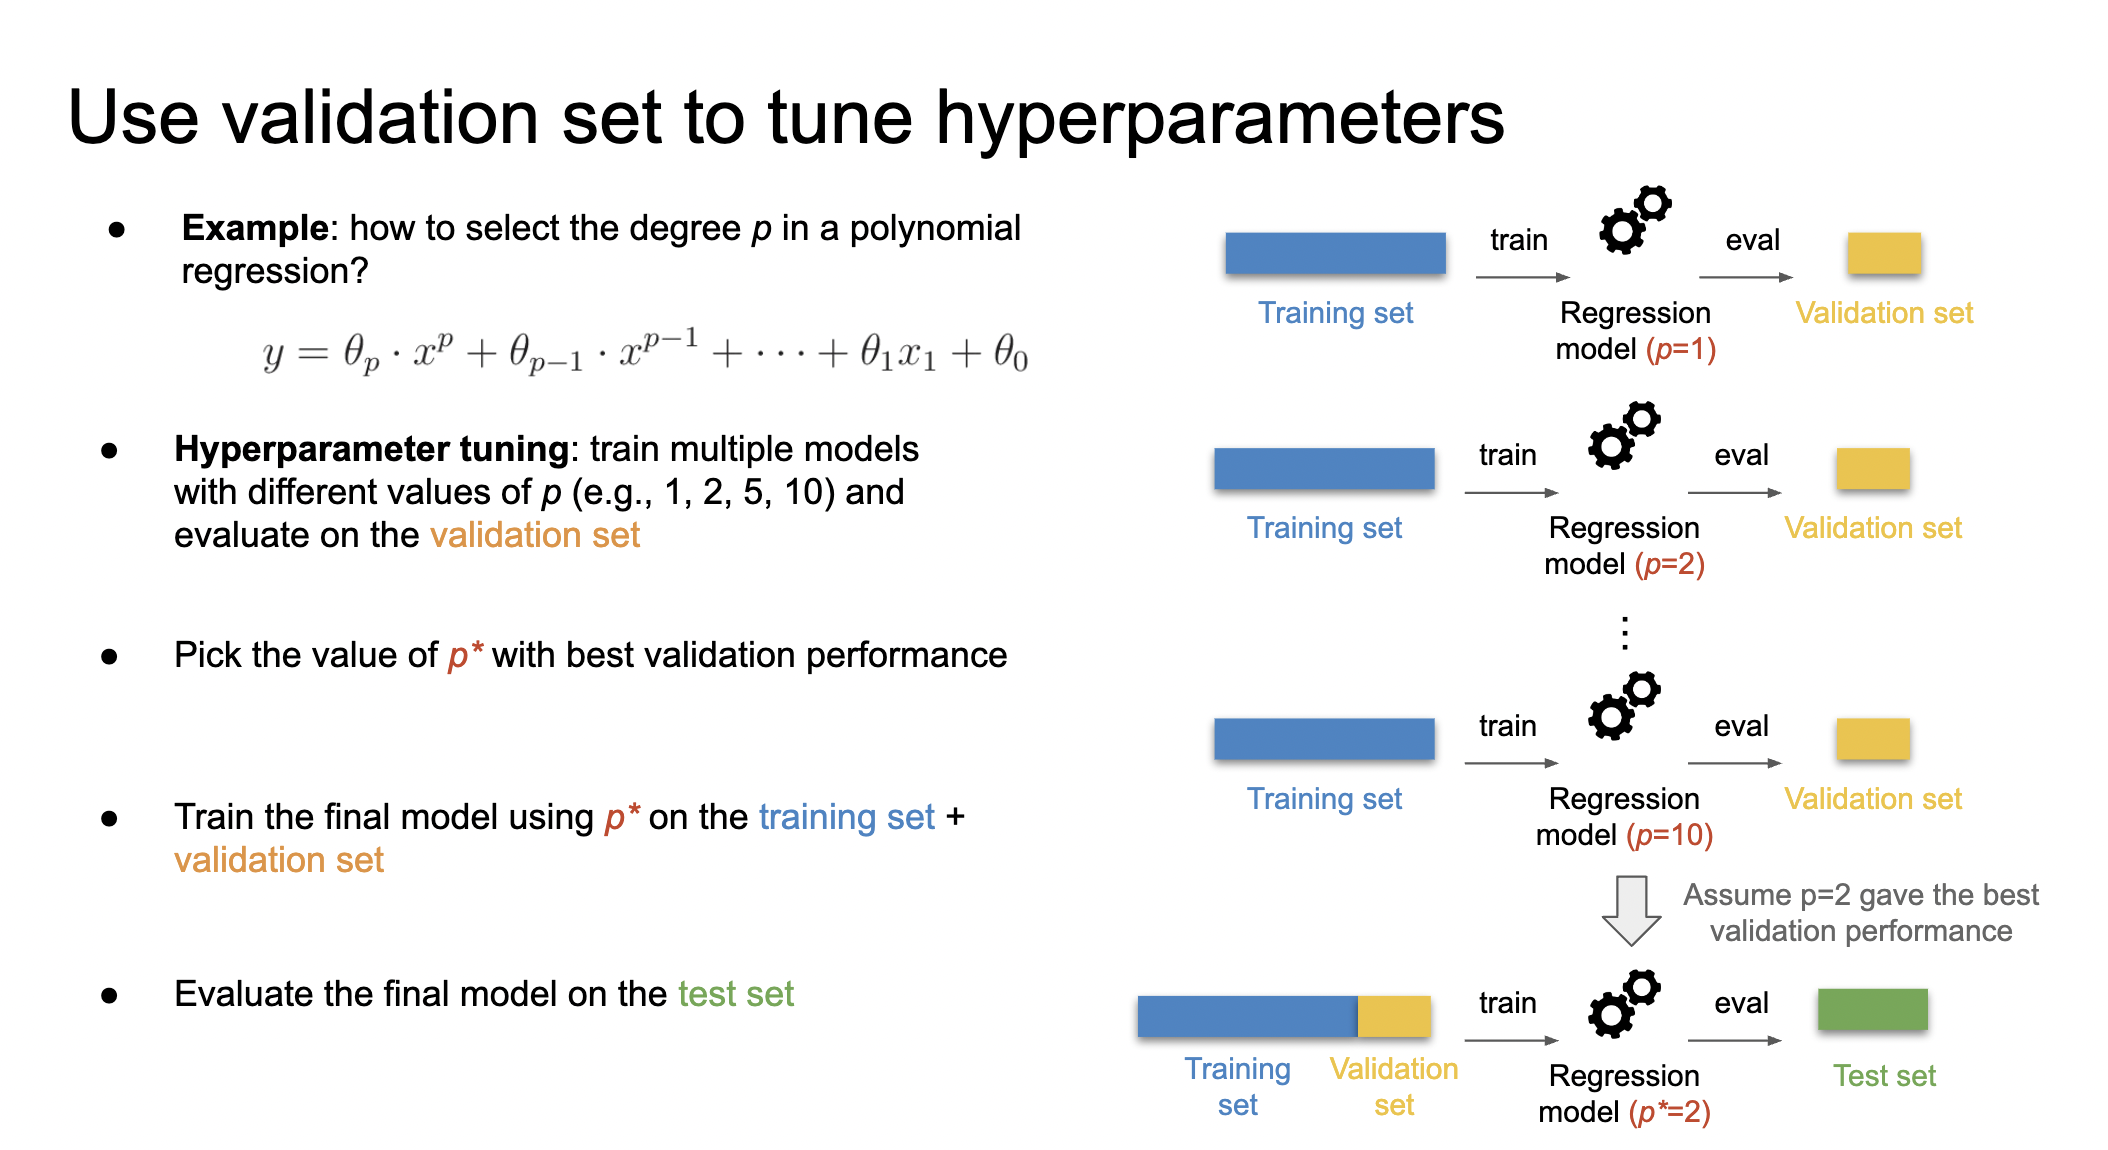

It is important to note that we used random split (not stratified) since this was the recommended split for Tox21 dataset in the MoleculeNet website. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_new_standarized, y, test_size=0.20, random_state=0)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=0)

Below we are installing the special library called hypopt which we used for grid search hyperparameter optimization using our specific validation set.

In [ ]:
pip install hypopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Below is the model development process for each of the three machine learning models we used for the non graph approach. For each of the machine learning models, we are using both the undersampling and oversampling technique to handle the imbalance data.


Additionally, we used two functions from the imbalanced-learn library (RandomUnderSampler() and SMOTE()) for perform undersampling and oversampling using the training set. We also created param_grids for all the three models to help during the grid search hyperparameter optimization process. 

## Logistic Regression

### Using Undersampling Technique

Let us look at the first example of applying the undersampling technique to train a logistic regression model. Below we are undersampling our training data using the RandomUnderSampler() function. We are assinging the undersampled data to different variables to ensure we do not modify the original training data. 

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='majority')
X_train_rus, y_train_rus = rus.fit_resample(X_train,y_train)

Now we will be performing the grid search hyperparameter optimization process. In this part, we will be first creating a param grid which contains all the hyperparameters as well as the possible values we want to explore. Then, we will use the GridSearch() function to get the optimal hyperparameter values using the validaton set as evaluation. 

In [ ]:
from hypopt import GridSearch
from sklearn.metrics import make_scorer

param_grid = [
   {'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
    'penalty' : ['l2'],
    'C': [100, 10, 1.0, 0.1, 0.01]}
 ]
 
 
gs = GridSearch(model = LogisticRegression(), param_grid = param_grid, parallelize=False)
gs.fit(X_train_rus, y_train_rus, X_val, y_val)

LogisticRegression(C=0.01, random_state=0, solver='liblinear')

As mentioned in the lecture slide shown above, we will now merge the training and validation dataset together once we have used the validation set to find the hyperparameter values.

In [ ]:
trainValCombinedX = pd.concat([pd.DataFrame(X_train_rus),pd.DataFrame(X_val)],axis=0)
trainValCombinedY = pd.concat([pd.DataFrame(y_train_rus),pd.DataFrame(y_val)],axis=0)

Using the merged dataset, we will now create a logistic regression model using the hyperparameter values we found during the hyperparameter optimization process. Then, we will fit the merged dataset as our training data. We will then use the testing set for evaluation. We are using AUROC score to evaluate our models.

In [ ]:
logisticReg = LogisticRegression(C = 0.01, random_state=0, solver="liblinear")
logisticReg.fit(trainValCombinedX,trainValCombinedY.squeeze())
prediction = logisticReg.predict(X_test)
roc_auc_score(y_test, logisticReg.predict_proba(X_test)[:, 1])

0.7816872913646019

We thought it would be interesting to also plot the ROC curve for each of the classification models. The below code was inspired from this website: https://www.statology.org/plot-roc-curve-python/

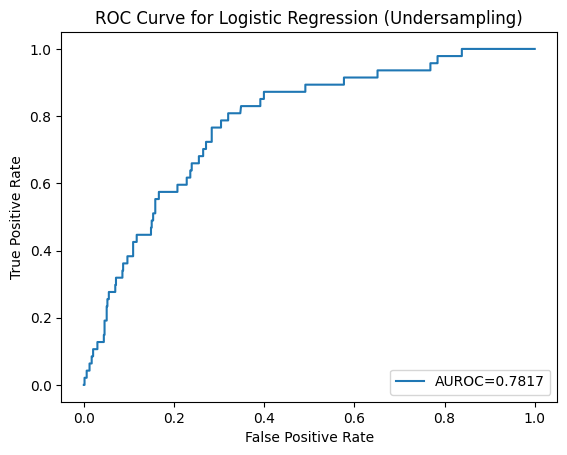

In [ ]:
falsePositiveRate, truePositiveRate, _ = metrics.roc_curve(y_test,  logisticReg.predict_proba(X_test)[:, 1])
plt.plot(falsePositiveRate,truePositiveRate, label="AUROC="+str(round(roc_auc_score(y_test, logisticReg.predict_proba(X_test)[:, 1]),4)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for Logistic Regression (Undersampling)')
plt.legend(loc=4)
plt.show()

The rest of the model development process is very similar to the one we just explored.

### Using Oversampling Technique

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='minority')
X_train_sm, y_train_sm = sm.fit_resample(X_train,y_train)

In [ ]:
from hypopt import GridSearch
from sklearn.metrics import make_scorer

param_grid = [
   {'solver' : ['newton-cg', 'lbfgs', 'liblinear'],
                       'penalty' : ['l2'],
                       'C': [100, 10, 1.0, 0.1, 0.01]
                      }
 ]
#scorer = make_scorer(roc_auc_score)
gs = GridSearch(model = LogisticRegression(), param_grid = param_grid, parallelize=False)
gs.fit(X_train_sm, y_train_sm, X_val, y_val)

LogisticRegression(C=0.01, random_state=0, solver='liblinear')

In [ ]:
trainValCombinedX = pd.concat([pd.DataFrame(X_train_sm),pd.DataFrame(X_val)],axis=0)
trainValCombinedY = pd.concat([pd.DataFrame(y_train_sm),pd.DataFrame(y_val)],axis=0)

In [ ]:
logisticReg = LogisticRegression(C = 0.01, random_state=0, solver="liblinear")
logisticReg.fit(trainValCombinedX,trainValCombinedY.squeeze())
prediction = logisticReg.predict(X_test)
roc_auc_score(y_test, logisticReg.predict_proba(X_test)[:, 1])

0.7843510806892133

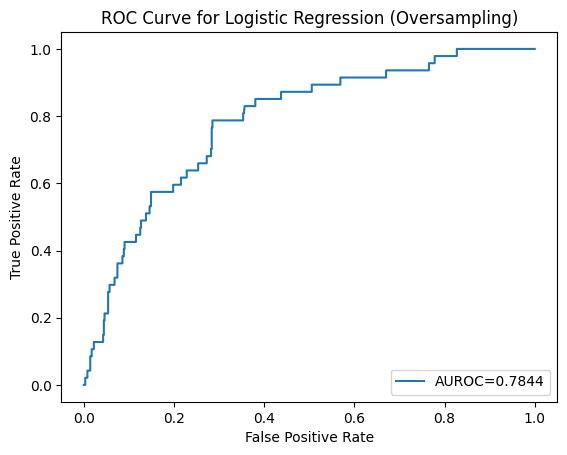

In [ ]:
falsePositiveRate, truePositiveRate, _ = metrics.roc_curve(y_test,  logisticReg.predict_proba(X_test)[:, 1])
plt.plot(falsePositiveRate,truePositiveRate, label="AUROC="+str(round(roc_auc_score(y_test, logisticReg.predict_proba(X_test)[:, 1]),4)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for Logistic Regression (Oversampling)')
plt.legend(loc=4)
plt.show()

## Support Vector Machine

### Using Undersampling Technique

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='majority')
X_train_rus, y_train_rus = rus.fit_resample(X_train,y_train)

In [ ]:
from hypopt import GridSearch
from sklearn.metrics import make_scorer
from sklearn.svm import SVC

param_grid = [
   {'kernel' : ['linear','rbf'],
                       'gamma' : ['scale'],
                       'C': [50, 10, 1.0, 0.1, 0.01]
                      }
 ]

#scorer = make_scorer(roc_auc_score)
gs = GridSearch(model = SVC(probability=True), param_grid = param_grid, parallelize=False)
gs.fit(X_train_rus, y_train_rus, X_val, y_val)

SVC(C=0.01, probability=True, random_state=0)

In [ ]:
trainValCombinedX = pd.concat([pd.DataFrame(X_train_rus),pd.DataFrame(X_val)],axis=0)
trainValCombinedY = pd.concat([pd.DataFrame(y_train_rus),pd.DataFrame(y_val)],axis=0)

In [ ]:
from sklearn import svm
svcClassifier = svm.SVC(C = 0.01, random_state=0,probability=True)
svcClassifier.fit(trainValCombinedX,trainValCombinedY.squeeze())
prediction = svcClassifier.predict(X_test)
roc_auc_score(y_test, svcClassifier.predict_proba(X_test)[:, 1])

0.7522338739589305

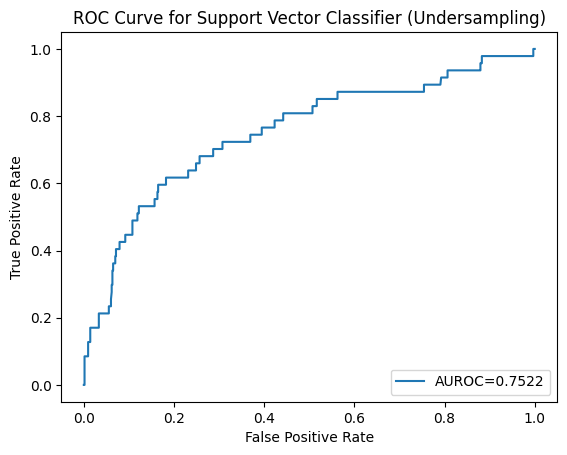

In [ ]:
falsePositiveRate, truePositiveRate, _ = metrics.roc_curve(y_test,  svcClassifier.predict_proba(X_test)[:, 1])
plt.plot(falsePositiveRate,truePositiveRate, label="AUROC="+str(round(roc_auc_score(y_test, svcClassifier.predict_proba(X_test)[:, 1]),4)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for Support Vector Classifier (Undersampling)')
plt.legend(loc=4)
plt.show()

### Using Oversampling Technique

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='minority')
X_train_sm, y_train_sm = sm.fit_resample(X_train,y_train)

In [ ]:
from hypopt import GridSearch
from sklearn.metrics import make_scorer

param_grid = [
   {'kernel' : ['linear'],
                       'gamma' : ['scale'],
                       'C': [50, 10, 1.0, 0.1, 0.01]
                      }
 ]

#scorer = make_scorer(roc_auc_score)
gs = GridSearch(model = SVC(probability=True), param_grid = param_grid, parallelize=False)
gs.fit(X_train_sm, y_train_sm, X_val, y_val)

SVC(C=0.01, kernel='linear', probability=True, random_state=0)

In [ ]:
trainValCombinedX = pd.concat([pd.DataFrame(X_train_sm),pd.DataFrame(X_val)],axis=0)
trainValCombinedY = pd.concat([pd.DataFrame(y_train_sm),pd.DataFrame(y_val)],axis=0)

In [ ]:
from sklearn import svm
svcClassifier = svm.SVC(C = 0.01, random_state=0, kernel="linear", probability=True)
svcClassifier.fit(trainValCombinedX,trainValCombinedY.squeeze())
prediction = svcClassifier.predict(X_test)
roc_auc_score(y_test, svcClassifier.predict_proba(X_test)[:, 1])

0.7842836429847928

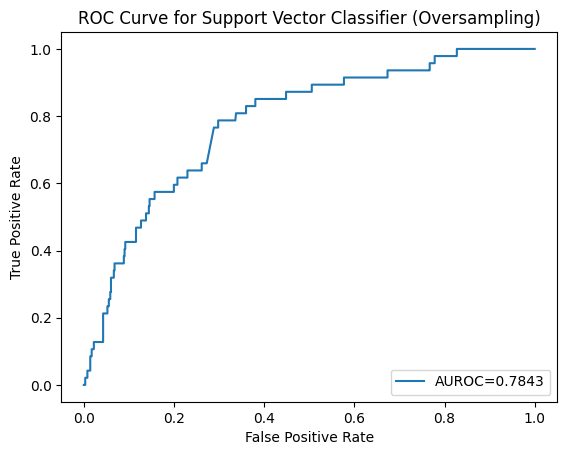

In [ ]:
falsePositiveRate, truePositiveRate, _ = metrics.roc_curve(y_test,  svcClassifier.predict_proba(X_test)[:, 1])
plt.plot(falsePositiveRate,truePositiveRate, label="AUROC="+str(round(roc_auc_score(y_test, svcClassifier.predict_proba(X_test)[:, 1]),4)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for Support Vector Classifier (Oversampling)')
plt.legend(loc=4)
plt.show()

## Random Forest Classifier


### Using Undersampling Technique

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy='majority')
X_train_rus, y_train_rus = rus.fit_resample(X_train,y_train)

In [ ]:
from hypopt import GridSearch
from sklearn.metrics import make_scorer

param_grid = [
   {'n_estimators' : [10, 100, 1000],
    'max_features' : ['sqrt', 'log2']}
 ]

#scorer = make_scorer(roc_auc_score)
gs = GridSearch(model = RandomForestClassifier(), param_grid = param_grid, parallelize=False)
gs.fit(X_train_rus, y_train_rus, X_val, y_val)

RandomForestClassifier(max_features='log2', n_estimators=1000, random_state=0)

In [ ]:
trainValCombinedX = pd.concat([pd.DataFrame(X_train_rus),pd.DataFrame(X_val)],axis=0)
trainValCombinedY = pd.concat([pd.DataFrame(y_train_rus),pd.DataFrame(y_val)],axis=0)

In [ ]:
from sklearn.metrics import average_precision_score
randomForestClassifier = RandomForestClassifier(n_estimators = 1000,
                                                max_features = 'log2',random_state=0)

randomForestClassifier.fit(trainValCombinedX,trainValCombinedY.squeeze())
predictions = randomForestClassifier.predict(X_test)
roc_auc_score(y_test, randomForestClassifier.predict_proba(X_test)[:, 1])

0.7627372964224298

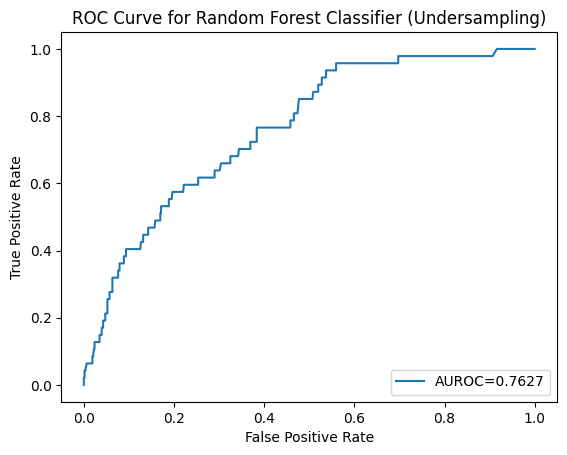

In [ ]:
falsePositiveRate, truePositiveRate, _ = metrics.roc_curve(y_test,  randomForestClassifier.predict_proba(X_test)[:, 1])
plt.plot(falsePositiveRate,truePositiveRate, label="AUROC="+str(round(roc_auc_score(y_test, randomForestClassifier.predict_proba(X_test)[:, 1]),4)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for Random Forest Classifier (Undersampling)')
plt.legend(loc=4)
plt.show()

### Using Oversampling Technique

In [ ]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='minority')
X_train_sm, y_train_sm = sm.fit_resample(X_train,y_train)

In [ ]:
from hypopt import GridSearch
from sklearn.metrics import make_scorer

param_grid = [
   {'n_estimators' : [10, 100, 1000],
    'max_features' : ['sqrt', 'log2']}
 ]

#scorer = make_scorer(roc_auc_score)
gs = GridSearch(model = RandomForestClassifier(), param_grid = param_grid, parallelize=False)
gs.fit(X_train_sm, y_train_sm, X_val, y_val)

RandomForestClassifier(max_features='log2', n_estimators=1000, random_state=0)

In [ ]:
trainValCombinedX = pd.concat([pd.DataFrame(X_train_sm),pd.DataFrame(X_val)],axis=0)
trainValCombinedY = pd.concat([pd.DataFrame(y_train_sm),pd.DataFrame(y_val)],axis=0)

In [ ]:
from sklearn.metrics import average_precision_score
randomForestClassifier = RandomForestClassifier(n_estimators = 1000,
                                                max_features = 'log2',random_state=0)

randomForestClassifier.fit(trainValCombinedX,trainValCombinedY.squeeze())
predictions = randomForestClassifier.predict(X_test)
roc_auc_score(y_test, randomForestClassifier.predict_proba(X_test)[:, 1])

0.7706275078396331

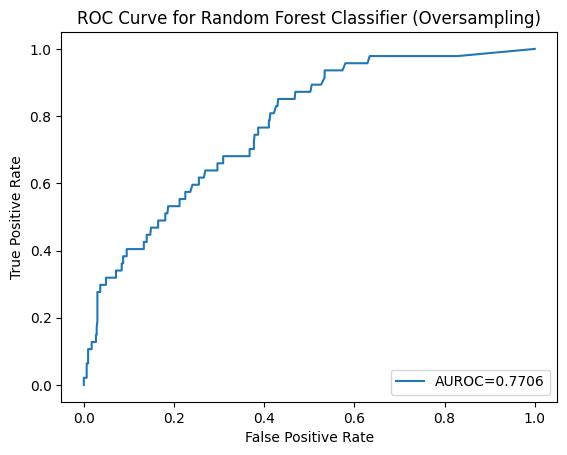

In [ ]:
falsePositiveRate, truePositiveRate, _ = metrics.roc_curve(y_test,  randomForestClassifier.predict_proba(X_test)[:, 1])
plt.plot(falsePositiveRate,truePositiveRate, label="AUROC="+str(round(roc_auc_score(y_test, randomForestClassifier.predict_proba(X_test)[:, 1]),4)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve for Random Forest Classifier (Oversampling)')
plt.legend(loc=4)
plt.show()

# Graph Approach (Using Graph Neural Network)



Below we are installing the libraries we will need to develop a GNN for classification.

In [ ]:
pip install torch.geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We are importing all the libraries for developing the GNN below.

In [ ]:
import pandas as pd

import numpy as np
import pandas as pd

from rdkit import Chem

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset

from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch


We are first getting the csv file values into a dataframe and then getting a subset of the dataframe consisting of two columns (smiles and SR-p53). Then, we are dropping the missing values from this dataframe. The reasoning for this is explaining in the non graph approach section. We are also converting the type of the target label values from float to int. 

In [ ]:
dataset = pd.read_csv("/content/tox21.csv")

In [ ]:
dataset = dataset[['smiles','SR-p53']]
dataset.dropna(inplace=True)
dataset['SR-p53'] = dataset['SR-p53'].astype("int")

In [ ]:
dataset

,smiles,SR-p53
0,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0
1,CCN1C(=O)NC(c2ccccc2)C1=O,0
3,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0
4,CC(O)(P(=O)(O)O)P(=O)(O)O,0
5,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,0
...,...,...
7825,CCCNCC(O)COc1ccccc1C(=O)CCc1ccccc1,0
7827,CC(=O)[C@H]1CC[C@H]2[C@@H]3CCC4=CC(=O)CC[C@]4(...,0
7828,C[C@]12CC[C@H]3[C@@H](CCC4=CC(=O)CC[C@@]43C)[C...,0
7829,C[C@]12CC[C@@H]3c4ccc(O)cc4CC[C@H]3[C@@H]1CC[C...,1


We are then shuffling the dataframe to ensure that there the target labels in the dataframe are in no specific order.

In [ ]:
dataset = dataset.sample(frac = 1)

Below we are converting all the SMILES strings from the smiles column of the dataframe into a graph representation. To be specific, we use the from_smiles() function from the torch_geometric.utils.smiles module to convert all the SMILES strings into an initial graph representation. For each initial graph, we create an updated graph that contains all the information in the initial graph as well as the SMILES string and the target label value for the specific chemical compound.

In [ ]:
from torch_geometric.utils import smiles
graphs = []
smilesList = list(dataset['smiles'])
targetLabels = list(dataset['SR-p53'])

for s in range(len(smilesList)):
  initialGraph = smiles.from_smiles(smilesList[s])
  graph = Data(x=initialGraph.x,
               edge_index=initialGraph.edge_index,
               edge_attr=initialGraph.edge_attr,
               smiles=smilesList[s],
               y=torch.LongTensor([targetLabels[s]]))
  graphs.append(graph)


We also create a custom PyTorch dataset because we felt it would simplify efforts when creating dataloaders for training, validation, and test sets.

In [ ]:
class Tox21Dataset(Dataset):
  def __init__(self):
    mols = graphs
    self.X = [m for m in mols if m]

  def __getitem__(self, idx):
    return self.X[idx]

  def __len__(self):
    return len(self.X)

In [ ]:
dataset = Tox21Dataset()

In [ ]:
dataset[0]

Data(x=[13, 9], edge_index=[2, 28], edge_attr=[28, 3], y=[1], smiles='Cc1cc(=O)oc2cc(O)ccc12')

Below we are dividing our dataset into training (80%), validation (10%), and testing (10%) portions. The implementation to this is very specific to homework three task four.

In [ ]:
torch.manual_seed(21)

train_dataset = dataset[:5419]
val_dataset = dataset[5419:6096]
test_dataset = dataset[6097:]

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of validation graphs: {len(val_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

Number of training graphs: 5419
Number of validation graphs: 677
Number of test graphs: 677


Below we are creating a dataloader for the training, validation, and testing set. 

In [ ]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
import torch

We are now designing the architecture for our GNN. This architecture was based off of homework three task four. However, it has different number of layers and uses different in and out channel values for each of the layers.

In [ ]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GraphGCN(torch.nn.Module):
    def __init__(self):
        super(GraphGCN, self).__init__()
        
        self.conv1 = GCNConv(9, 64)
        self.conv2 = GCNConv(64,32)
        self.lin1 = Linear(32, 2)
       

    def forward(self, x, edge_index, batch):
        
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x,edge_index)
        x = global_mean_pool(x, batch)  
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin1(x)
        
        return x

model = GraphGCN()
print(model)

GraphGCN(
  (conv1): GCNConv(9, 64)
  (conv2): GCNConv(64, 32)
  (lin1): Linear(in_features=32, out_features=2, bias=True)
)


In [ ]:
device="cpu"

In [ ]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Below we will see the implementation for the train() and test() functions. The implementation for these functions is very similar to homework three task four. We are using MultilabelAUROC to calculate the AUROC value. Additionally we used weighted average since the documentation mentioned that this average accounts for class imbalance. We are also using 200 epochs.

In [ ]:
from torchmetrics.classification import MultilabelAUROC
from torchmetrics import AUROC

model = GraphGCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
lossFunction = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    total_loss = 0.0
    for data in train_loader: 
        out = model(data.x.type(torch.float).to(device), data.edge_index.to(device), data.batch.to(device))  
        loss = lossFunction(out, data.y.to(device))  
        total_loss += loss
        loss.backward() 
        optimizer.step()  
        optimizer.zero_grad()  
    return total_loss / len(train_loader)

def test(testloader):
     model.eval()
     auroc_score = 0.0
     auroc = AUROC(num_labels=2,average="weighted",task="multilabel")
     with torch.no_grad():
       for data in testloader:
         out = model(data.x.type(torch.float).to(device), data.edge_index.to(device),data.batch.to(device))
         sigmoid = torch.nn.Sigmoid()
         probabilites = sigmoid(out)
         newDataForm = []
         for i in data.y:
           if (i == 1):
             newDataForm.append([0,1])
           else:
             newDataForm.append([1,0])
         newDataForm = torch.Tensor(newDataForm)
         auroc.update(probabilites,newDataForm.type(torch.int))
     

     auroc_score = auroc.compute()
        
     return auroc_score


for epoch in range(200):
    train_loss = train()
    train_auroc = test(train_loader)
    valid_auroc = test(val_loader)

    print(f'Epoch: {epoch:03d}, Train Loss: {train_loss:.5f}, Train Auc: {train_auroc:.4f}, Valid Auc: {valid_auroc:.4f}')

Epoch: 000, Train Loss: 0.26334, Train Auc: 0.6407, Valid Auc: 0.5540
Epoch: 001, Train Loss: 0.23510, Train Auc: 0.6732, Valid Auc: 0.6021
Epoch: 002, Train Loss: 0.22965, Train Auc: 0.6813, Valid Auc: 0.6114
Epoch: 003, Train Loss: 0.22835, Train Auc: 0.6802, Valid Auc: 0.6104
Epoch: 004, Train Loss: 0.22648, Train Auc: 0.6873, Valid Auc: 0.6220
Epoch: 005, Train Loss: 0.22511, Train Auc: 0.6976, Valid Auc: 0.6297
Epoch: 006, Train Loss: 0.22273, Train Auc: 0.6960, Valid Auc: 0.6326
Epoch: 007, Train Loss: 0.22237, Train Auc: 0.7066, Valid Auc: 0.6429
Epoch: 008, Train Loss: 0.22013, Train Auc: 0.7079, Valid Auc: 0.6464
Epoch: 009, Train Loss: 0.22306, Train Auc: 0.7088, Valid Auc: 0.6500
Epoch: 010, Train Loss: 0.22321, Train Auc: 0.7114, Valid Auc: 0.6542
Epoch: 011, Train Loss: 0.22087, Train Auc: 0.7128, Valid Auc: 0.6549
Epoch: 012, Train Loss: 0.21902, Train Auc: 0.7146, Valid Auc: 0.6598
Epoch: 013, Train Loss: 0.21962, Train Auc: 0.7157, Valid Auc: 0.6624
Epoch: 014, Train Lo

In [ ]:
test(test_loader)

tensor(0.8105)